# Question

Is there an easy way to merge circuits, so take 3 pregenerated circuits and merge them to one big one?

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

# 1. Try for steane typ QEC code

Using a surface 17 code of distance 3.


In [59]:
# Stabilizers for the 3 distance surface17 code
Z_stabilizers = [
    [1,0,0,1,0,0,0,0,0],
    [0,0,0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0,0,0],
    [0,0,0,0,0,1,0,0,1]
    ]
X_stabilizers = [
    [0,1,1,0,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,1,1],
    [0,0,0,0,0,0,1,1,0]
    ]

def generate_qubit_indices(
        circuit,
        gen_x_stabilizer:bool=True, 
        gen_z_stabilizer:bool=True,
        ):
    """
    We are starting from the last used qubit and generate the indices of:
    9 data qubits 
    4 Z measure qubits
    4 X measure qubits
    and returns those as a dict
    """
    data_qubits = np.arange(circuit.num_qubits, circuit.num_qubits + 9)
    circuit.append("R", data_qubits)
    log_qubit_indices = {
        "data": data_qubits,
        }
    if gen_z_stabilizer:
        Z_measure_qubits = np.arange(circuit.num_qubits,circuit.num_qubits + 4)
        circuit.append("R", Z_measure_qubits)
        log_qubit_indices.update({ 
            "Z_measure": Z_measure_qubits,
        })
    if gen_x_stabilizer:
        X_measure_qubits = np.arange(circuit.num_qubits,circuit.num_qubits + 4)
        circuit.append("R", X_measure_qubits)
        log_qubit_indices.update({ 
            "X_measure": X_measure_qubits,
        })
    return circuit, log_qubit_indices 

def add_stabilizer(
        circuit, 
        gen_x_stabilizer=True, 
        gen_z_stabilizer=True, 
        log_qubit_indices=None,
        ):
    """
    Adds a surface 17 stabilizer qubit to the circuit, with the given qubits
    with the option to turn off the not needed stabilizer qubits
    """
    if not log_qubit_indices:
        circuit, log_qubit_indices = generate_qubit_indices(circuit,gen_x_stabilizer,gen_z_stabilizer)
    data_qubits = log_qubit_indices["data"]

    if gen_z_stabilizer:
        Z_measure_qubits = log_qubit_indices["Z_measure"]
        # Z stabilizers: C(data)NOT(measure)
        for i,stabilizer in enumerate(Z_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                # CxNOTy (of the list) "CNOT",[x,y]
                circuit.append("CNOT",[data_qubits[j],Z_measure_qubits[i]])
        circuit.append("MR", Z_measure_qubits)
        circuit.append("TICK")

    if gen_x_stabilizer:
        X_measure_qubits = log_qubit_indices["X_measure"]
        # X stabilizers: H(measure) C(measure)NOT(data) H(measure)
        circuit.append("H",X_measure_qubits)
        circuit.append("TICK")
        for i,stabilizer in enumerate(X_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                circuit.append("CNOT",[X_measure_qubits[i],data_qubits[j]])
        circuit.append("TICK")
        circuit.append("H",X_measure_qubits)
        circuit.append("TICK")
        circuit.append("MR", X_measure_qubits)
        circuit.append("TICK")
    return circuit,  log_qubit_indices


In [62]:
def gen_steane_circuit(
                       surface_code=False,
                       aux_p_qubit_used=True,
                       aux_0_qubit_used=True,
                       ):
    if surface_code:
        aux_0_qubit_used = False
        aux_p_qubit_used = False
    # surface_code = True if I just want to simulate a surface 17 code
    steane_circuit = stim.Circuit()
    # generate indices & initialize qubits
    steane_circuit, general_qubit = add_stabilizer(steane_circuit, gen_z_stabilizer=False)

    # The second set of stabilizers is just needed for the surface 17 code
    if surface_code:
        steane_circuit, = add_stabilizer(steane_circuit, general_qubit, )
        i_first_x_stab_measure = 4
        n_stab_measures = 4
        for i in range(n_stab_measures):
            rel_index_old_measurement = (i_first_x_stab_measure + i) - steane_circuit.num_measurements 
            rel_index_new_measurement = i - n_stab_measures 
            steane_circuit.append("DETECTOR",[stim.target_rec(rel_index_old_measurement),stim.target_rec(rel_index_new_measurement)])
        #TODO write code to check Z stabiliser as well
    
    if aux_0_qubit_used:
        measurements_before_aux_0 = steane_circuit.num_measurements
        # initalize aux qubit
        steane_circuit, aux_0_qubit = add_stabilizer(steane_circuit, gen_z_stabilizer=False)
        steane_circuit.append("TICK")
        # entangle aux qubit 
        for i, _ in enumerate(general_qubit["data"]):
                steane_circuit.append("CNOT",[aux_0_qubit["data"][i],general_qubit["data"][i]])
        steane_circuit.append("TICK")
        # measure aux qubit 
        steane_circuit.append("H",aux_0_qubit["data"])
        steane_circuit.append("MR",aux_0_qubit["data"])
        steane_circuit.append("TICK")
        # Set up Detectors 
        # They have to be deterministic! (XORing each input) 
        # encoding parity =(needs to be) measured parity [eg: rec(0) + rec(4) = rec(9) + rec(10)] => detector(0,4,9,10)
        x = measurements_before_aux_0
        detection_sets = [
            [0,0+x,5+x,6+x], 
            [1,1+x,4+x,5+x,7+x,8+x], 
            [2,2+x,8+x,9+x,11+x,12+x],
            [3,3+x,10+x,11+x],
        ]
        del x # cleanup the temp variable
        for i, set in enumerate(detection_sets):
            rel_index = [x - steane_circuit.num_measurements for x in set]
            steane_circuit.append("DETECTOR",
            [stim.target_rec(x) for x in rel_index]
                                  ) 
        steane_circuit.append("TICK")

    if aux_p_qubit_used:
        measurements_before_aux_0 = steane_circuit.num_measurements
        # initialize aux qubit
        steane_circuit, aux_p_qubit = generate_qubit_indices(steane_circuit, gen_x_stabilizer=False)
        steane_circuit.append("H",aux_p_qubit["data"]) # initalize in |+>-state
        steane_circuit, _, = add_stabilizer(
            steane_circuit, 
            gen_x_stabilizer=False, 
            log_qubit_indices=aux_p_qubit
            )
        steane_circuit.append("TICK")
        # entangle aux qubit
        for i, _ in enumerate(general_qubit["data"]):
            steane_circuit.append("CNOT",[general_qubit["data"][i],aux_p_qubit["data"][i]])
        steane_circuit.append("TICK")
        # measure aux qubit
        steane_circuit.append("MR",aux_p_qubit["data"])
        # Set up Detectors
        x = measurements_before_aux_0
        detection_sets = [
            [0+x,4+x,7+x], 
            [1+x,7+x,8+x,10+x,11+x], 
            [2+x,5+x,6+x,8+x,9+x],
            [3+x,9+x,12+x],
        ]
        del x 
        for i, set in enumerate(detection_sets):
            rel_index = [x - steane_circuit.num_measurements for x in set]
            steane_circuit.append("DETECTOR",
            [stim.target_rec(x) for x in rel_index]
                                  ) 
        steane_circuit.append("TICK")

    # measure general qubit
    steane_circuit.append("M",general_qubit["data"])
    steane_circuit.append("OBSERVABLE_INCLUDE",[stim.target_rec(-(i+1)) for i in range(9)],0)
    steane_circuit.append("TICK")
    return steane_circuit

steane_circuit = gen_steane_circuit(
                                    aux_0_qubit_used=True,
                                    aux_p_qubit_used=True,
                                    )
steane_circuit.diagram("timeline-svg")

if 1:
    diagram = steane_circuit.diagram("timeline-svg")  
    with open('my_circuit.svg', 'w') as f:
        f.write(str(diagram))


In [75]:
def add_noise(circuit,noise_model):
    noisy_circuit = stim.Circuit()
    # def of possible errors
    single_qubit_gate_op = ["H"]
    two_qubit_gate_op = ["CX"]
    initalize_op = ["R"]
    measurement_op = ["M","MR"]

    for circuit_instruction in circuit:
        # Errors before operation
        if circuit_instruction.name in measurement_op: 
            noisy_circuit.append(
                noise_model["measurement"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["measurement"]["noise"],
            )

        # Original operation
        noisy_circuit.append(circuit_instruction)

        # Errors after operation
        if circuit_instruction.name in single_qubit_gate_op: 
            noisy_circuit.append(
                noise_model["single_qubit_gate"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["single_qubit_gate"]["noise"],
                )
        elif circuit_instruction.name in initalize_op: 
            noisy_circuit.append(
                noise_model["initialize"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["initialize"]["noise"],
            )
        elif circuit_instruction.name in two_qubit_gate_op:
            noisy_circuit.append(
                noise_model["two_qubit_gate"]["error"],
                circuit_instruction.targets_copy(),
                noise_model["two_qubit_gate"]["noise"],
            )

    return noisy_circuit

# noise model is stolen from the paper "Demonstration of fault-tolerant Steane quantum error correction"
# but only parts are implemented 
noise_model = {
    "single_qubit_gate": {
        "error": "DEPOLARIZE1",
        "noise": 0.0036,
    },
    "two_qubit_gate": {
        "error": "DEPOLARIZE2",
        "noise": 0.027,
    },
    "measurement": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
    "initialize": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
}

noisy_circuit = add_noise(steane_circuit,noise_model)
if 1:
    diagram = noisy_circuit.diagram("timeline-svg")  
    with open('noisy_circuit.svg', 'w') as f:
        f.write(str(diagram))

In [ ]:
# The CNOTS gates entangle with the original qubits => they need to be taken into account !
# do the mathhhhh!

sampler = steane_circuit.compile_detector_sampler()
print(sampler.sample(shots=1))

[[False False False False False False False False]]


In [ ]:
dem = steane_circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
    detector D5
    detector D6
    detector D7
    logical_observable L0
''')


In [76]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [79]:
num_shots = 100_000
num_logical_errors = count_logical_errors(noisy_circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 31488 wrong predictions (logical errors) out of 100000 shots


/tmp/ipykernel_22165/2522760665.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


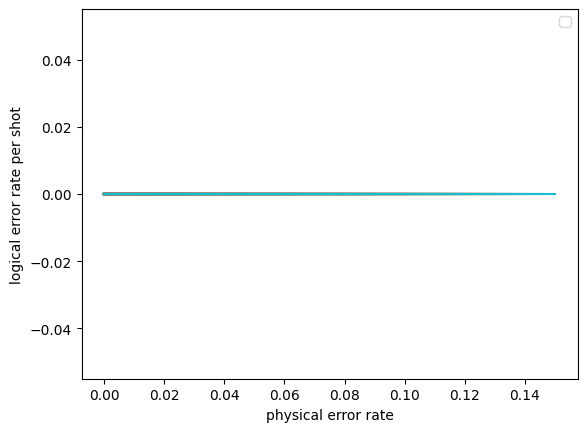

In [ ]:

num_shots = 10_000
#for circuit in [gen_steane_circuit(1)]:
if 1:
    xs = []
    ys = []
    for noise in np.linspace(0,0.15):
        circuit = gen_steane_circuit(
            noise,
            aux_0_qubit_used=True,
            aux_p_qubit_used=False, 
            )
        diagram = circuit.diagram('timeline-svg')
        with open('problem.svg', 'w') as f:
            f.write(str(diagram))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
        plt.plot(xs,ys)
#plt.loglog()
#plt.plot(np.linspace(0,0.15),np.linspace(0,0.15))
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()